In [129]:
import anndata as AnnD
#msdata = AnnD.read_h5ad("Data/PRJNA544731_human_brain_snRNAseq_ms_nature_2019.h5ad")
#del msdata.obs['||']
#del msdata.obs['>Description']
#msdata.obs['>Description'] = ['Human brain snRNAseq 46k cells (MS Nature 2019 Schirmer et al.); data - normalized, log transformed and scaled UMI; platform - 10X v2 chemistry | embedding by umap_harmony; color by cell_type']*msdata.n_obs
#msdata.write("Data/PRJNA544731_human_brain_snRNAseq_ms_nature_2019_new.h5ad")

msdata = AnnD.read_h5ad("Data/tabula-muris.h5ad")
#del msdata.obs['||']
del msdata.obs['>Description']
msdata.obs['>Description'] = ['Tabula Muris is a compendium of single cell transcriptome data from the model organism Mus musculus; data - normalized, log transformed UMI; platform - 10X v2 chemistry | embedding by umap; color by tissue']*msdata.n_obs
msdata.write("Data/tabula-muris_new.h5ad")





... storing 'Description' as categorical


In [1]:
import requests
import sys
from importlib import reload
import random
from IPython.core.display import HTML


import plotly.graph_objects as go
import plotly.io as plotIO
import pickle

import math
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import base64
from io import BytesIO
import json
import seaborn as sns
import diffxpy.api as de
import server.app.decode_fbs as decode_fbs
api_version = "/api/v0.2"

sc.set_figure_params(dpi=80, color_map='viridis')
sc.settings.verbosity = 2
sc.logging.print_versions()
rcParams.update({'figure.autolayout': True})

# height="300" width="300"
html= """
  <html><body>
  <img src="data:image/png;base64,{}"/>
  </body></html>
  """
class appConfig:
    server__host="127.0.0.1"
    server__port=8888
    
appC = appConfig()

#D = sc.read_h5ad("Data/tabula-muris.h5ad")

scanpy==1.4.7.dev152+g245a480 anndata==0.7.3 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1


In [3]:
#import pickle
#with open("sankey.pkl",'rb') as f:
#    fig = pickle.load(f)
#fig.show()
#if not 'AnnData' in str(type(adata1)):
#  raise ValueError("")
#adata1

In [21]:
import diffxpy.api as de
try:
  res = de.test.two_sample(adata1,'Custom_combine',test='t-test')
  deg = res.summary()
except Exception as e:
  d = type(e)
  print('{}: {}'.format(type(e),str(e)))
deg

<class 'NameError'>: name 'adata1' is not defined


NameError: name 'deg' is not defined

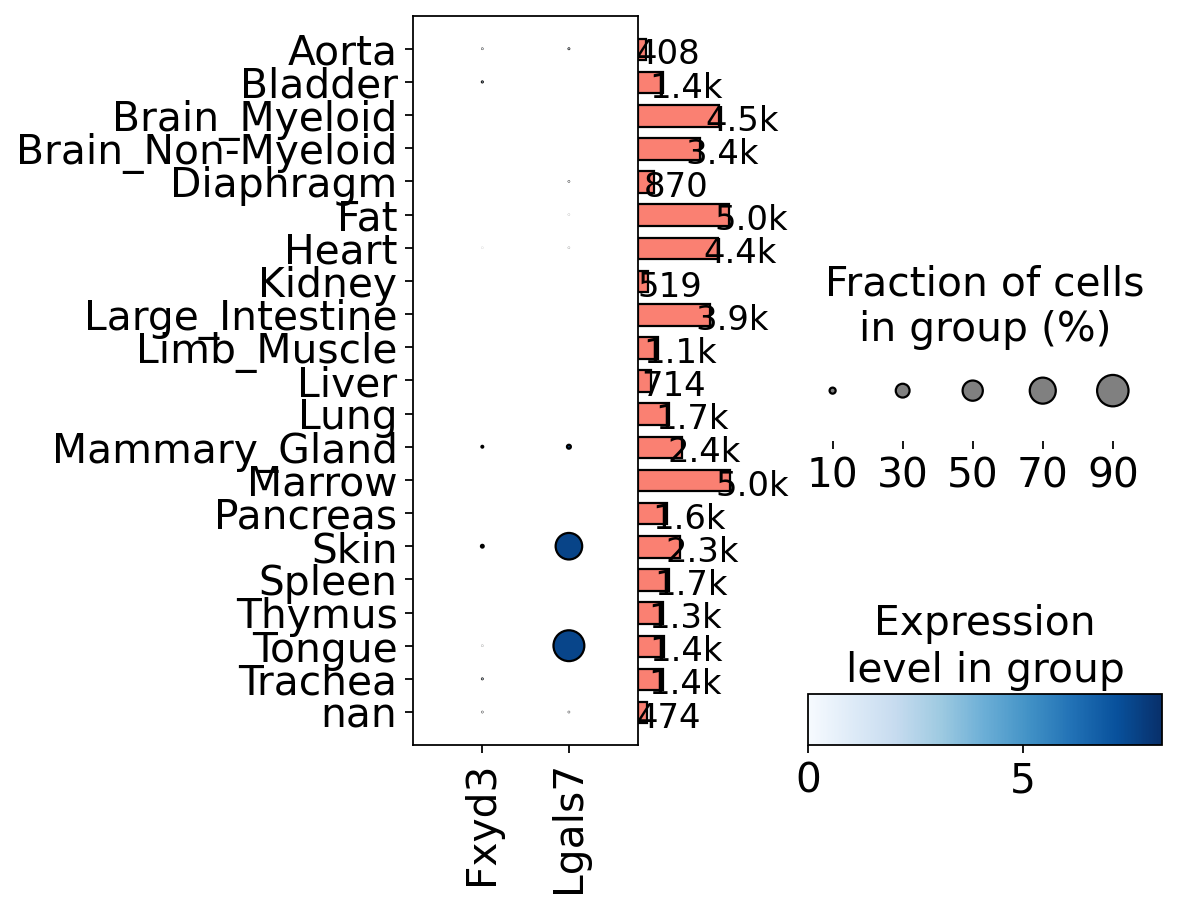

In [25]:
sc.set_figure_params(fontsize=22)
dp = sc.pl.dotplot(adata,data['genes'],groupby=data['grp'],expression_cutoff=float(data['cutoff']),mean_only_expressed=(data['mean_only_expressed'] == 'Yes'),
                       return_fig=True,figsize=(6,6))#
dp = dp.add_totals(size=0.8).legend(show_size_legend=True,width=3).style(cmap='Blues', dot_edge_color='black', dot_edge_lw=1, size_exponent=1.5)
dp.show()

In [105]:
Y = X#adata.to_df()
gNames = ['BTK','SALL1','FXYD3','ACTA2','KRT5']
if not type(Y) is np.ndarray:
  Y = pd.DataFrame.sparse.from_spmatrix(Y,columns=gNames)
data['geneGrp'] = {'set1':['BTK','SALL1'],'set2':['FXYD3','ACTA2','KRT5']}#{'set1':['Fxyd3','Lgals7'],'set2':['Acta2','Krt5','Cd79a'],'set3':['Rac2','Coro1a']}
data['genes'] = gNames
for aN in data['geneGrp'].keys():
  Y = pd.concat([Y,Y[data['geneGrp'][aN]].mean(axis=1).rename(aN)],axis=1,sort=False)
  for gene in data['geneGrp'][aN]:
    if gene in data['genes']:
      data['genes'].remove(gene)
  data['genes'] += [aN] 
#Y
#len(data['geneGrp'])
data['genes']

['set1', 'set2']

In [112]:
list(Y.columns)

['BTK', 'SALL1', 'FXYD3', 'ACTA2', 'KRT5', 'set1', 'set2']

In [48]:
def cleanAbbr(data):
  updated = False
  if 'abb' in data.keys() and 'combine' in data.keys():
    if len(data['combine'])>0:
      updated = True
      for cate in data['abb'].keys():
        if cate in data['combine'].keys():
          for anName in data['abb'][cate].keys():
            if not anName in data['combine'][cate]:
              data['abb'][cate][anName] = "Other";
        else:
          data['abb'][cate] = {key:"Other" for key in data['abb'][cate].keys()}
  return updated

def subData(data,scD):
  selC = list(data['cells'].values())
  cNames = ["cell%d" %i for i in selC]
  
  ## onbtain the expression matrix
  gNames = []
  expr = []
  if True:
    fSparse = False
    X = []
    if 'genes' in data.keys():
      if not type(scD.X) is np.ndarray:
        fSparse = True
      if len(data['genes'])>0:
        fullG = list(scD.var.index)
        selG = [fullG.index(i) for i in data['genes']]
        X = scD.X[selC][:,selG]
        gNames = data['genes']
      else:
        X = scD.X[selC]
        gNames = list(scD.var.index)
    if fSparse:
      expr = X
    else:
      expr = pd.DataFrame(X,columns=gNames,index=cNames)
  ## obtain the embedding
  strEmbed = 'umap'
  #embed = pd.DataFrame([[0 for x in range(len(cNames))] for i in range(2)],
  #                      index=['%s1'%strEmbed,'%s2'%strEmbed],columns=cNames).T
  embed = pd.DataFrame([],index=cNames)
  if 'layout' in data.keys():## tsne or umap
    strEmbed = data['layout']
    #with app.get_data_adaptor() as scD:
    embed = pd.DataFrame(scD.obsm['X_%s'%strEmbed][selC],columns=['%s1'%strEmbed,'%s2'%strEmbed],index=cNames)

  ## obtain the category annotation
  #with app.get_data_adaptor() as scD:
  obs = scD.obs.iloc[selC,].loc[:,data['grp']].astype('str')
  #obs['name_0'] = list(scD.obs.index)
  obs.index = cNames

  ## update the annotation Abbreviation
  combUpdate = cleanAbbr(data)
  if 'abb' in data.keys():
    for i in data['grp']:
      obs[i] = obs[i].map(data['abb'][i])

  ## create a custom annotation category and remove cells which are not in the selected annotation
  if combUpdate and len(data['grp'])>1:
    newGrp = 'Custom_combine'
    obs[newGrp] = obs[data['grp'][0]]
    for i in data['grp']:
      if i!=data['grp'][0]:
        obs[newGrp] += "_"+obs[i]
    selC = ~obs[newGrp].str.contains("Other").to_numpy()
    expr = expr[selC]
    embed = embed[selC]
    obs = obs[selC]
    data['grp'] = [newGrp]
    
  obs = obs.astype('category')
  ## empty selection
  if expr.shape[0]==0 or expr.shape[1]==0:
    return []
  return sc.AnnData(expr,obs,var=pd.DataFrame([],index=gNames),obsm={'X_%s'%strEmbed:embed.to_numpy()})
adata = subData(data,scD)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [108]:
gNames = ['Btk','Acta2','Cd79a']
fullG = list(D.var.index)
selG = [fullG.index(i) for i in gNames]
X = D.X[:,selG]

adata = sc.AnnData(pd.DataFrame(X,columns=gNames))

/home/oyoung/anaconda3/envs/cellxgene/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [27]:
X = adata.to_df().apply(lambda x:pd.cut(x,10))
adata.to_df().apply(lambda x:pd.cut(x,10).apply(lambda y:x.name+":"+'%.1f_%.1f'%(y.left,y.right)))

BTK           SALL1
cell33569  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell33485  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell33473  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell33779  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell29075  BTK:-0.0_1.0  SALL1:-0.0_0.6
...                 ...             ...
cell19913  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell17110  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell12902  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell12584  BTK:-0.0_1.0  SALL1:-0.0_0.6
cell3549   BTK:-0.0_1.0  SALL1:-0.0_0.6

[20000 rows x 2 columns]


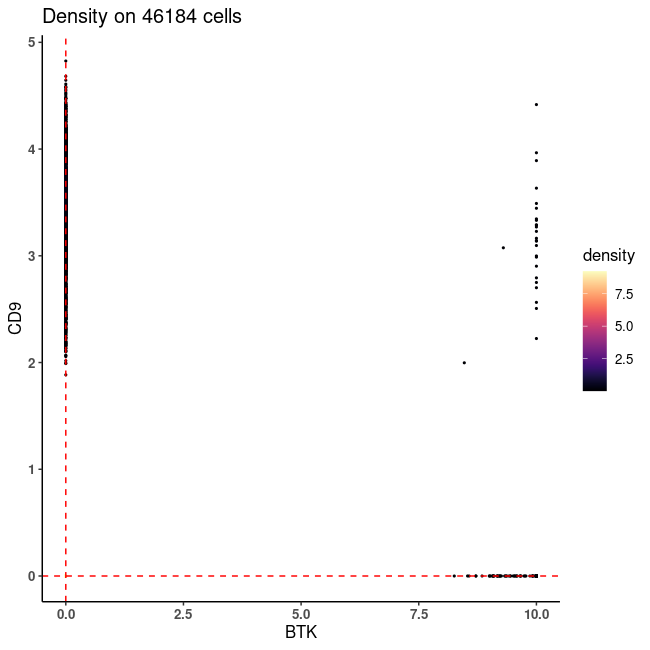

In [26]:
import os
import subprocess

strExePath = './newV'
strF = "test.csv"
adata.to_df()[['BTK','CD9']].to_csv(strF)
res = subprocess.run([strExePath+'/Density2D.R',strF,'png','-1','magma','12','100'],capture_output=True)#
if 'Error' in res.stderr.decode('utf-8'):
  raise ValueError(res.stderr.decode('utf-8'))
img = res.stdout.decode('utf-8')
#os.remove(strF)
html= """
  <html><body>
  <div><img src="data:image/png;base64,{}"/></div>
  </body></html>
  """
HTML(html.format(img))

In [28]:
#res.stderr.decode('utf-8')
#adata.to_df()[['BTK','CD9']]
#pd.concat(adata.obs)
adata.obs['None'] = 'all'
adata.obs

cell_type diagnosis None
cell0              OL        MS  all
cell1              OL   Control  all
cell2      Astrocytes   Control  all
cell3      Astrocytes        MS  all
cell4             OPC        MS  all
...               ...       ...  ...
cell46179    IN-PVALB   Control  all
cell46180          OL        MS  all
cell46181    IN-PVALB   Control  all
cell46182  Phagocytes        MS  all
cell46183     EN-L5-6   Control  all

[46184 rows x 3 columns]

In [60]:
D = sc.read_h5ad("Data/tabula-muris.h5ad")
D.obs['cluster'] = [random.randint(1,20) for x in range(D.obs.shape[0])]
cix = list(range(D.shape[0]))#random.sample(range(D.shape[0]),40000)
cells = {str(x):cix[x] for x in range(len(cix))}
selC = list(cells.values())
cNames = ["cell%d" %i for i in selC]
obs = D.obs.iloc[selC,:].loc[:,["mouse_sex","tissue"]].astype('str')#"cluster",,"cell_ontology_class"
obs.index = cNames

gNames = ['Fxyd3','Lgals7','Acta2','Krt5','Cd79a','Rac2','Coro1a']#['Btk','Cd93']#,'Acta2','Krt5','Cd79a','Rac2','Coro1a','Acta2','Krt5','Cd79a'
data={'genes':gNames,'grp':'tissue','cutoff':7,'mean_only_expressed':'Yes'}
fullG = list(D.var.index)
selG = [fullG.index(i) for i in gNames]#
X = D.X[selC][:,selG]
obs = obs.astype('category')
strEmbed = 'umap'
embed = pd.DataFrame(D.obsm['X_%s'%strEmbed][selC],columns=['%s1'%strEmbed,'%s2'%strEmbed],index=cNames)
adata = sc.AnnData(pd.DataFrame(X,columns=gNames,index=cNames),
                   obs,var=pd.DataFrame([],index=gNames),
                   obsm={'X_%s'%strEmbed:embed.to_numpy()})
#a = list(set(list(adata.obs['cluster'])))
#adata.to_df().to_csv()

In [2]:
D = sc.read_h5ad("Data/PRJNA544731_human_brain_snRNAseq_ms_nature_2019_new.h5ad")
#D.obs['cluster'] = [random.randint(1,20) for x in range(D.obs.shape[0])]
#cells = {str(x):random.randint(1,46183) for x in range(10000)}
#Icells = [i for i in range(D.shape[0]) if D.obs.loc[:,'cell_type'][i]=='OL' or D.obs.loc[:,'cell_type'][i]=='OPC']
#cells ={str(x):Icells[x] for x in range(len(Icells))}
cix = list(range(D.shape[0]))#random.sample(range(D.shape[0]),40000)
cells = {str(x):cix[x] for x in range(len(cix))}

selC = list(cells.values())
cNames = ["cell%d" %i for i in selC]
obs = D.obs.iloc[selC,:].loc[:,["cell_type","diagnosis"]].astype('str')#"cluster",,"cell_ontology_class"
obs.index = cNames

gNames = ['BTK','SALL1','FXYD3','ACTA2','KRT5','CD9']#['FXYD3','ACTA2']#['Fxyd3','Lgals7','Acta2','Krt5','Cd79a']#['Btk','Cd93']#,'Acta2','Krt5','Cd79a','Rac2','Coro1a'
fullG = list(D.var.index)
selG = [fullG.index(i) for i in gNames]#
X = D.X[selC][:,selG]
obs = obs.astype('category')
strEmbed = 'umap_harmony'
embed = pd.DataFrame(D.obsm['X_%s'%strEmbed][selC],columns=['%s1'%strEmbed,'%s2'%strEmbed],index=cNames)
adata = sc.AnnData(X,
                   obs,var=pd.DataFrame([],index=gNames),
                   obsm={'X_%s'%strEmbed:embed.to_numpy()})
#a = list(set(list(adata.obs['cluster'])))
#adata.to_df().to_csv()

In [114]:
#adata.obs
sc.tl.rank_genes_groups(adata,groupby='cell_type',n_genes=1,method='logreg')

ranking genes


ValueError: mismatch between the number of fields and the number of arrays

In [94]:
summaryOne[oneName[1]].apply(lambda x: print(x))

SALL1:-0.0_0.6
SALL1:2.3_2.8
SALL1:2.8_3.4
SALL1:3.4_4.0
SALL1:4.0_4.5
SALL1:4.5_5.1
SALL1:5.1_5.7


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
14    None
18    None
19    None
Name: SALL1, dtype: object

In [92]:
#with open("adata.pkl",'rb') as f:
#    adata = pickle.load(f)   
#adata.to_df().apply(lambda x:pd.cut(x,10).apply(lambda y:x.name+":"+'%.1f_%.1f'%(y.left,y.right)))
adata = adataH
D= pd.concat([adata.obs.apply(lambda x:x.apply(lambda y:x.name+":"+y)),
                   adata.to_df().apply(lambda x:pd.cut(x,10).apply(lambda y:x.name+":"+'%.1f_%.1f'%(y.left,y.right)))],#adata.to_df().apply(lambda x:pd.cut(x,10,labels=False).apply(lambda y:x.name+":"+str(y)))
                  axis=1,sort=False)
D = D.astype('str').astype('category')
if 'name_0' in D.columns:
  del D['name_0']
if True:  
  colName =['Set1','Set3','viridis']
  labels = []
  cols = []
  colindex = 0
  for gID in D.columns:
    gNames = list(D[gID].unique())
    labels += gNames
    if len(gNames) <10:
      cols += sns.color_palette(colName[colindex%2],len(gNames)).as_hex()
      colindex += 1
    else:
      cols += sns.color_palette(colName[2],len(gNames)).as_hex()
  
  sIDs =[]
  dIDs =[]
  v=[]
  Dnames = list(D.columns)#data['sankOrder']#
  #maxGrp = 0
  #ppr.pprint(Dnames)
  for i in range(len(Dnames)-1):
    oneName = Dnames[i:i+2]
    #maxGrp = max(maxGrp,len(D[oneName[0]].unique()))
    summaryOne = D.groupby(oneName).size().reset_index(name='Count')
    summaryOne=summaryOne[summaryOne['Count']>0]
    sIDs += list(summaryOne[oneName[0]].apply(lambda x: labels.index(x)))
    dIDs += list(summaryOne[oneName[1]].apply(lambda x: labels.index(x)))
    v += list(summaryOne['Count'])
    
  data_trace = dict(
    type='sankey',
    domain=dict(x=[0,1],y=[0,1]),
    orientation='h',
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 15,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  labels,
      color =  cols
    ),
    link = dict(
      source = sIDs,
      target = dIDs,
      value = v
    )
  )
  


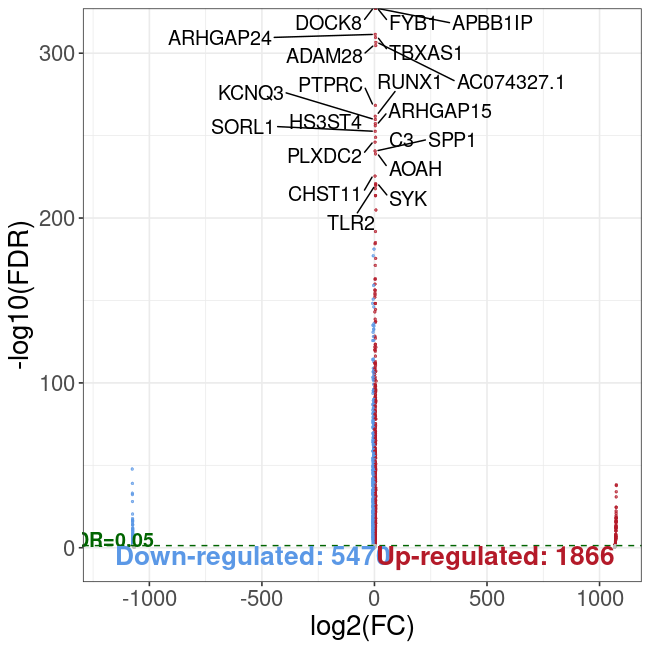

In [51]:
import subprocess
#X = pd.read_csv('DEG1591986591.144738.csv',index_col=0)
#txt = X.to_csv('DEG1591986591.144738.csv',index=False)
res = subprocess.run(['newV/volcano.R','DEG1591986591.144738.csv','','png','20','100'],capture_output=True)
#with open("DEG1591986591.144738.base64",'r') as f:
#  img = f.read()
#svg+xml
html= """
  <html><body>
  <div><img src="data:image/png;base64,{}"/></div>
  </body></html>
  """
HTML(html.format(res.stdout.decode('utf-8')))

In [52]:
res = subprocess.run(['newV/volcano.R','DEG1591986591.144738.csv','','svg','20','150'],capture_output=True)
html= """
  <html><body>
  <div><img src="data:image/svg+xml;base64,{}"/></div>
  </body></html>
  """
HTML(html.format(res.stdout.decode('utf-8')))

In [44]:
res

CompletedProcess(args=['newV/volcano.R', 'DEG1591986591.144738.csv', '', 'png', '12', '100'], returncode=1, stdout=b'', stderr=b'Error in .geometry(width, height, units, res) : \n  \'res\' must be specified unless \'units = "px"\'\nCalls: f -> .geometry\nExecution halted\n')

In [26]:
def getSankey(adata):
  D = pd.concat([adata.obs.apply(lambda x:x.apply(lambda y:x.name+":"+y)),
                 adata.to_df().apply(lambda x:pd.cut(x,10,labels=False).apply(lambda y:x.name+":"+'%.1f_%.1f'%(y.left,y.right)))],
                axis=1,sort=False)
  #print(D)
  D = D.astype('category')
  if 'name_0' in D.columns:
    del D['name_0']

  colName =['Set1','Set3','viridis']
  labels = []
  cols = []
  colindex = 0
  for gID in D.columns:
    gNames = list(D[gID].unique())
    labels += gNames
    if len(gNames) <10:
      cols += sns.color_palette(colName[colindex%2],len(gNames)).as_hex()
      colindex += 1
    else:
      cols += sns.color_palette(colName[2],len(gNames)).as_hex()
  
  sIDs =[]
  dIDs =[]
  v=[]
  Dnames = list(D.columns)
  #maxGrp = 0
  for i in range(D.shape[1]-1):
    oneName = Dnames[i:i+2]
    #maxGrp = max(maxGrp,len(D[oneName[0]].unique()))
    summaryOne = D.groupby(oneName).size().reset_index(name='Count')
    summaryOne=summaryOne[summaryOne['Count']>0]
    sIDs += list(summaryOne[oneName[0]].apply(lambda x: labels.index(x)))
    dIDs += list(summaryOne[oneName[1]].apply(lambda x: labels.index(x)))
    v += list(summaryOne['Count'])
    
  data_trace = dict(
    type='sankey',
    #width = 100*D.shape[1],
    #height= D.shape[0]/10,
    domain=dict(x=[0,1],y=[0,1]),
    orientation='h',
    valueformat = ".0f",
    valuesuffix = "TWh",
    node = dict(
      pad = 10,
      thickness = 15,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  labels,
      color =  cols
    ),
    link = dict(
      source = sIDs,
      target = dIDs,
      value = v
    )
  )
  layoutImg = dict(
    title = 'Sankey diagram',
    font = dict(size=15),
    width = 200*D.shape[1],
    height= 700
  )
  layout = dict(
    title = 'Sankey diagram',
    font = dict(size=15),
    width = 200*D.shape[1],
    height= 700,
    updatemenus= [
            dict(
                y=1,
                buttons=[
                    dict(
                        label='Light',
                        method='relayout',
                        args=['paper_bgcolor', 'white']
                    ),
                    dict(
                        label='Dark',
                        method='relayout',
                        args=['paper_bgcolor', 'black']
                    )
                ]
            
            ),
            dict(
                y=0.9,
                buttons=[
                    dict(
                        label='Thick',
                        method='restyle',
                        args=['node.thickness', 15]
                    ),
                    dict(
                        label='Thin',
                        method='restyle',
                        args=['node.thickness', 8]
                    )      
                ]
            ),
            dict(
                y=0.8,
                buttons=[
                    dict(
                        label='Small gap',
                        method='restyle',
                        args=['node.pad', 15]
                    ),
                    dict(
                        label='Large gap',
                        method='restyle',
                        args=['node.pad', 20]
                    )
                ]
            ),
            dict(
                y=0.7,
                buttons=[
                    dict(
                        label='Snap',
                        method='restyle',
                        args=['arrangement', 'snap']
                    ),
                    dict(
                        label='Perpendicular',
                        method='restyle',
                        args=['arrangement', 'perpendicular']
                    ),
                    dict(
                        label='Freeform',
                        method='restyle',
                        args=['arrangement', 'freeform']
                    ),
                    dict(
                        label='Fixed',
                        method='restyle',
                        args=['arrangement', 'fixed']
                    )       
                ]
            ),
            dict(
                y=0.6,
                buttons=[             
                    dict(
                        label='Horizontal',
                        method='restyle',
                        args=['orientation', 'h']
                    ),
                    dict(
                        label='Vertical',
                        method='restyle',
                        args=['height', 2500]
                    )
                ]
            
            )
        ]    
  )
  fig = go.Figure(data=[go.Sankey(data_trace)],layout=layoutImg)
  #fig.show()
  #with open("sankey.pkl",'wb') as f:
  #  pickle.dump(fig,f)
  return plotIO.to_image(fig,'svg')

#with open("adata.pkl",'rb') as f:
#    adata = pickle.load(f)
html1= """
  <html><body>
  <div><img src="data:image/svg+xml;base64,{}"/></div>
  </body></html>
  """
img = getSankey(adata)
img = base64.encodebytes(img).decode('utf-8')
HTML(html1.format(img))

In [20]:
import AnnData as AnnD
msdata = AnnD.read_h5ad("PRJNA544731_human_brain_snRNAseq_ms_nature_2019.h5ad")
del msdata.obs['||']
del msdata.obs['>Description']
msdata.obs['>Description'] = ['Human brain snRNAseq 46k cells (MS Nature 2019 Schirmer et al.); data - normalized, log transformed and scaled UMI; platform - 10X v2 chemistry | embedding by umap_harmony; color by cell_type']*msdata.n_obs
msdata.write("PRJNA544731_human_brain_snRNAseq_ms_nature_2019.h5ad")

True

In [68]:
div[div.find('<div>'):(div.find('</div>')+6)]

'<div>\n        \n                <script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: \'local\'};</script>\n        <script type="text/javascript">/**\n* plotly.js v1.54.1\n* Copyright 2012-2020, Plotly, Inc.\n* All rights reserved.\n* Licensed under the MIT license\n*/\n!function(t){if("object"==typeof exports&&"undefined"!=typeof module)module.exports=t();else if("function"==typeof define&&define.amd)define([],t);else{("undefined"!=typeof window?window:"undefined"!=typeof global?global:"undefined"!=typeof self?self:this).Plotly=t()}}((function(){return function t(e,r,n){function a(o,s){if(!r[o]){if(!e[o]){var l="function"==typeof require&&require;if(!s&&l)return l(o,!0);if(i)return i(o,!0);var c=new Error("Cannot find module \'"+o+"\'");throw c.code="MODULE_NOT_FOUND",c}var u=r[o]={exports:{}};e[o][0].call(u.exports,(function(t){return a(e[o][1][t]||t)}),u,u.exports,t,e,r,n)}return r[o].exports}for(var i="function"==typeof require&&require,o=0;o<n.length;o++)a(n[o]);

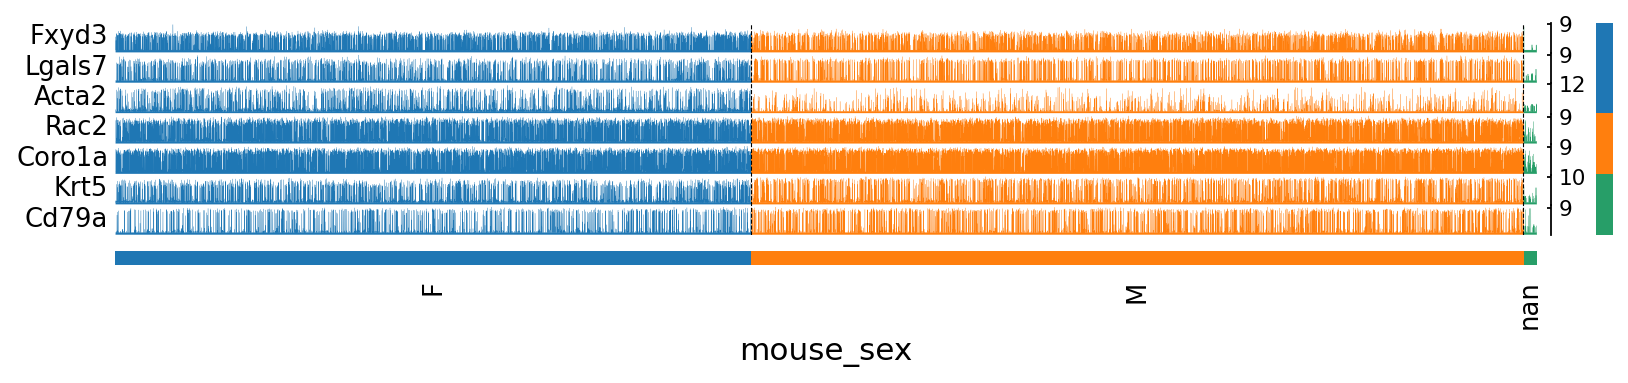

In [21]:
def unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def updateGene(data):
  grpID = []
  grpLoc=[]
  allG = []
  if 'geneGrp' in data.keys():
    for aN in data['geneGrp'].keys():
      grpLoc += [(len(allG),len(allG)+len(data['geneGrp'][aN])-1)]
      allG += data['geneGrp'][aN]
      grpID += [aN]
  data['genes'] = unique(allG+data['genes'])
  data['grpLoc'] = grpLoc
  data['grpID'] = grpID
geneD = {'genes':gNames,'geneGrp':{'set1':['Fxyd3','Lgals7','Acta2'],'set2':['Rac2','Coro1a']}}#
updateGene(geneD)
#sc.pl.stacked_violin(adata,gTotal,'mouse_sex',var_group_positions=setP,var_group_labels=list(geneSet.keys()))
#dp = sc.pl.dotplot(adata,geneD['genes'],groupby='tissue',expression_cutoff=float(data['cutoff']),
#                   var_group_positions=geneD['grpLoc'],var_group_labels=geneD['grpID'],return_fig=True)#
#dp = dp.add_totals(size=1.2).legend(show_size_legend=True).style(cmap='Blues', dot_edge_color='black', dot_edge_lw=1, size_exponent=1.5)
#dp.show()
#print(geneD['grpID'])
#print(geneD['grpLoc'])
if geneD['grpLoc'][len(geneD['grpLoc'])-1][1] < (len(geneD['genes'])-1):
  geneD['grpLoc'] += [(geneD['grpLoc'][len(geneD['grpLoc'])-1][1]+1,len(geneD['genes'])-1)]
  geneD['grpID'] += ['others']
fig = sc.pl.tracksplot(adata,geneD['genes'],groupby='mouse_sex',
                       var_group_positions=geneD['grpLoc'],var_group_labels=geneD['grpID'])

In [50]:
fig[7].get_geometry()

(9, 2, 4)

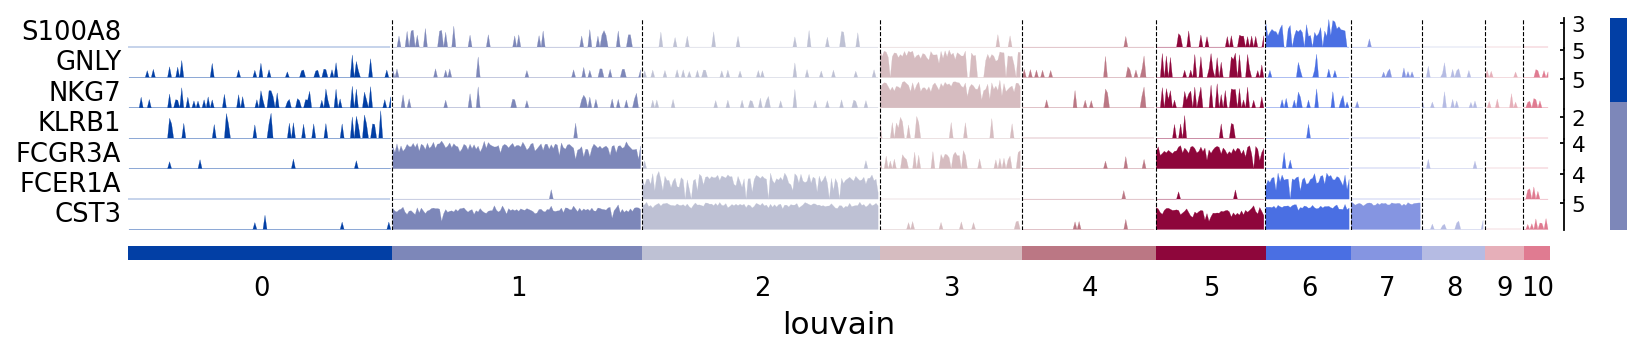

In [14]:
pbmc = sc.datasets.pbmc68k_reduced()
marker_genes = ['S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'FCER1A', 'CST3']

ax = sc.pl.tracksplot(pbmc,marker_genes, groupby='louvain',
                     var_group_positions=[(0,1),(4,6)],var_group_labels=['set1','set2'])

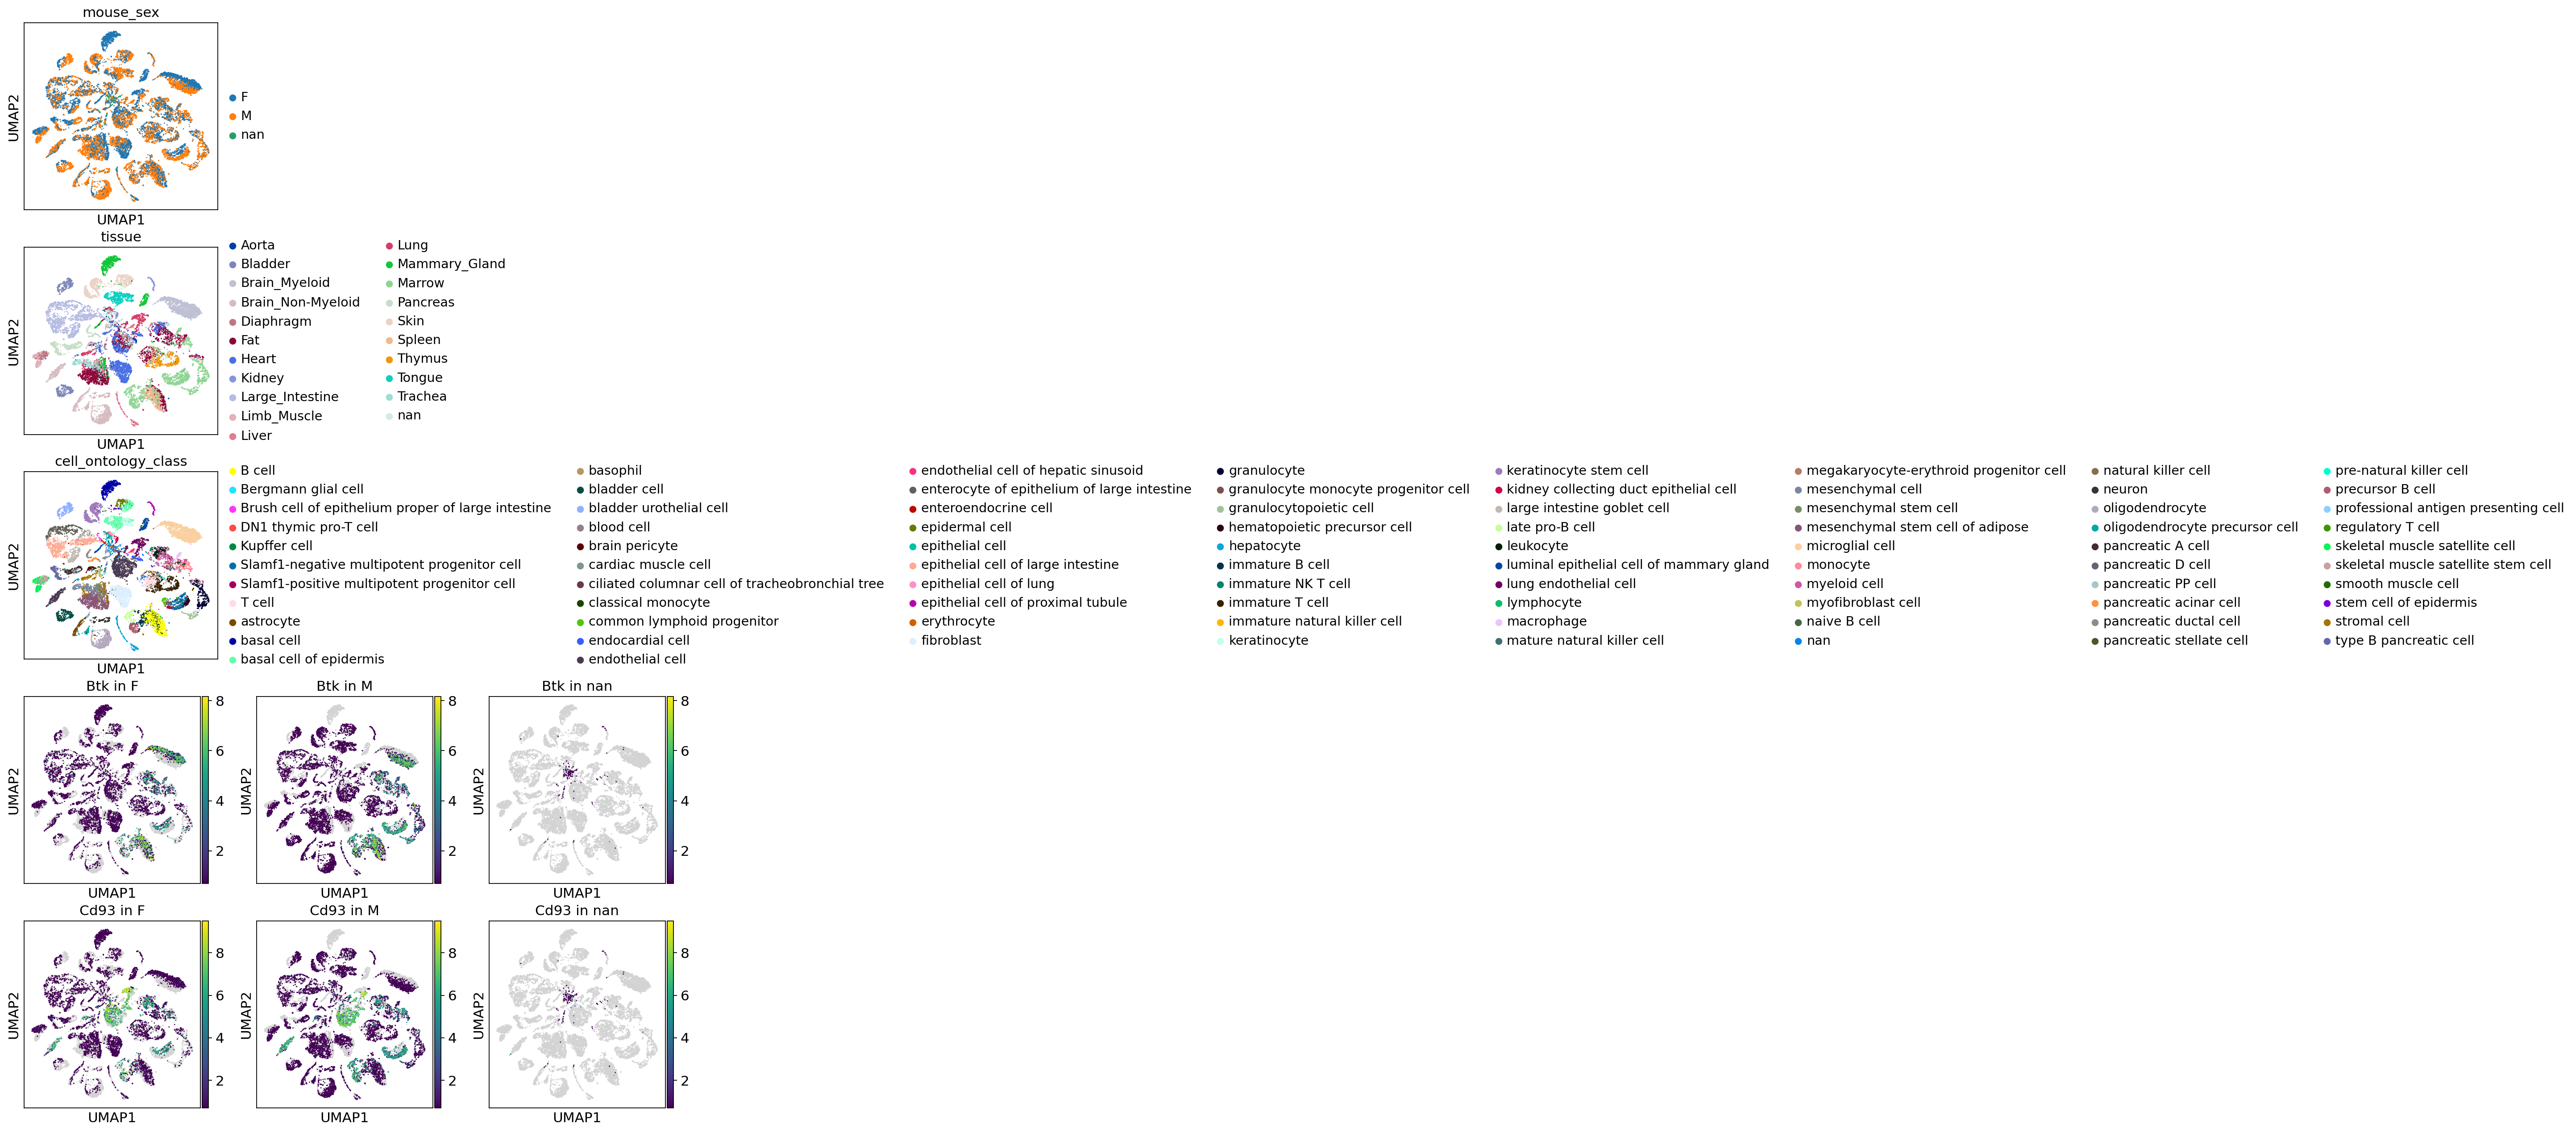

In [179]:

  subSize = 4
  ncol = 4
  data['grp'] = ["mouse_sex","tissue","cell_ontology_class"]
  data['genes'] = adata.var.index
  data['splitGrp'] = 'mouse_sex'
  ngrp = len(data['grp'])
  ngene = len(data['genes'])
  nrow = ngrp+math.ceil(ngene/ncol)
  if 'splitGrp' in data.keys():
    splitName = list(D.obs[data['splitGrp']].unique())
    nsplitRow = math.ceil(len(splitName)/ncol)
    nrow = ngrp+ngene*nsplitRow
  
  step =11
  grpCol = {gID:math.ceil(len(list(adata.obs[gID].unique()))/step) for gID in data['grp']}
  
  rcParams['figure.constrained_layout.use'] = False
  fig = plt.figure(figsize=(ncol*subSize,subSize*nrow))
  gs = fig.add_gridspec(nrow,ncol,wspace=0.2)
  for i in range(ngrp):
      ax = getattr(sc.pl,data['layout'])(adata=adata,color=data['grp'][i],ax=fig.add_subplot(gs[i,0]),show=False)
      if grpCol[data['grp'][i]]>1:
          ax.legend(ncol=grpCol[data['grp'][i]],loc=6,bbox_to_anchor=(1,0.5),frameon=False)

  if 'splitGrp' in data.keys():
    vMax = adata.to_df().apply(lambda x: max(x))
    vMin = adata.to_df().apply(lambda x: min(x))
    dotSize = 120000 / adata.n_obs
    for i in range(ngene):
      for j in range(len(splitName)):
        x = ngrp + i*nsplitRow+int(j/ncol)
        y = j % ncol
        ax = getattr(sc.pl,data['layout'])(adata,ax=fig.add_subplot(gs[x,y]),show=False)#color=data['genes'][i],wspace=0.25,
        getattr(sc.pl,data['layout'])(adata[adata.obs[data['splitGrp']]==splitName[j]],color=data['genes'][i],
                vmin=vMin[data['genes'][i]],vmax=vMax[data['genes'][i]],ax=ax,wspace=0.25,show=False,
                size=dotSize,title='{} in {}'.format(data['genes'][i],splitName[j]))
  else:
    for i in range(ngene):
        x = int(i/ncol)+ngrp
        y = i % ncol
        getattr(sc.pl,data['layout'])(adata,color=data['genes'][i],ax=fig.add_subplot(gs[x,y]),wspace=0.25,show=False)




In [156]:
D.obsm.X_umap

AttributeError: 'AxisArrays' object has no attribute 'X_umap'

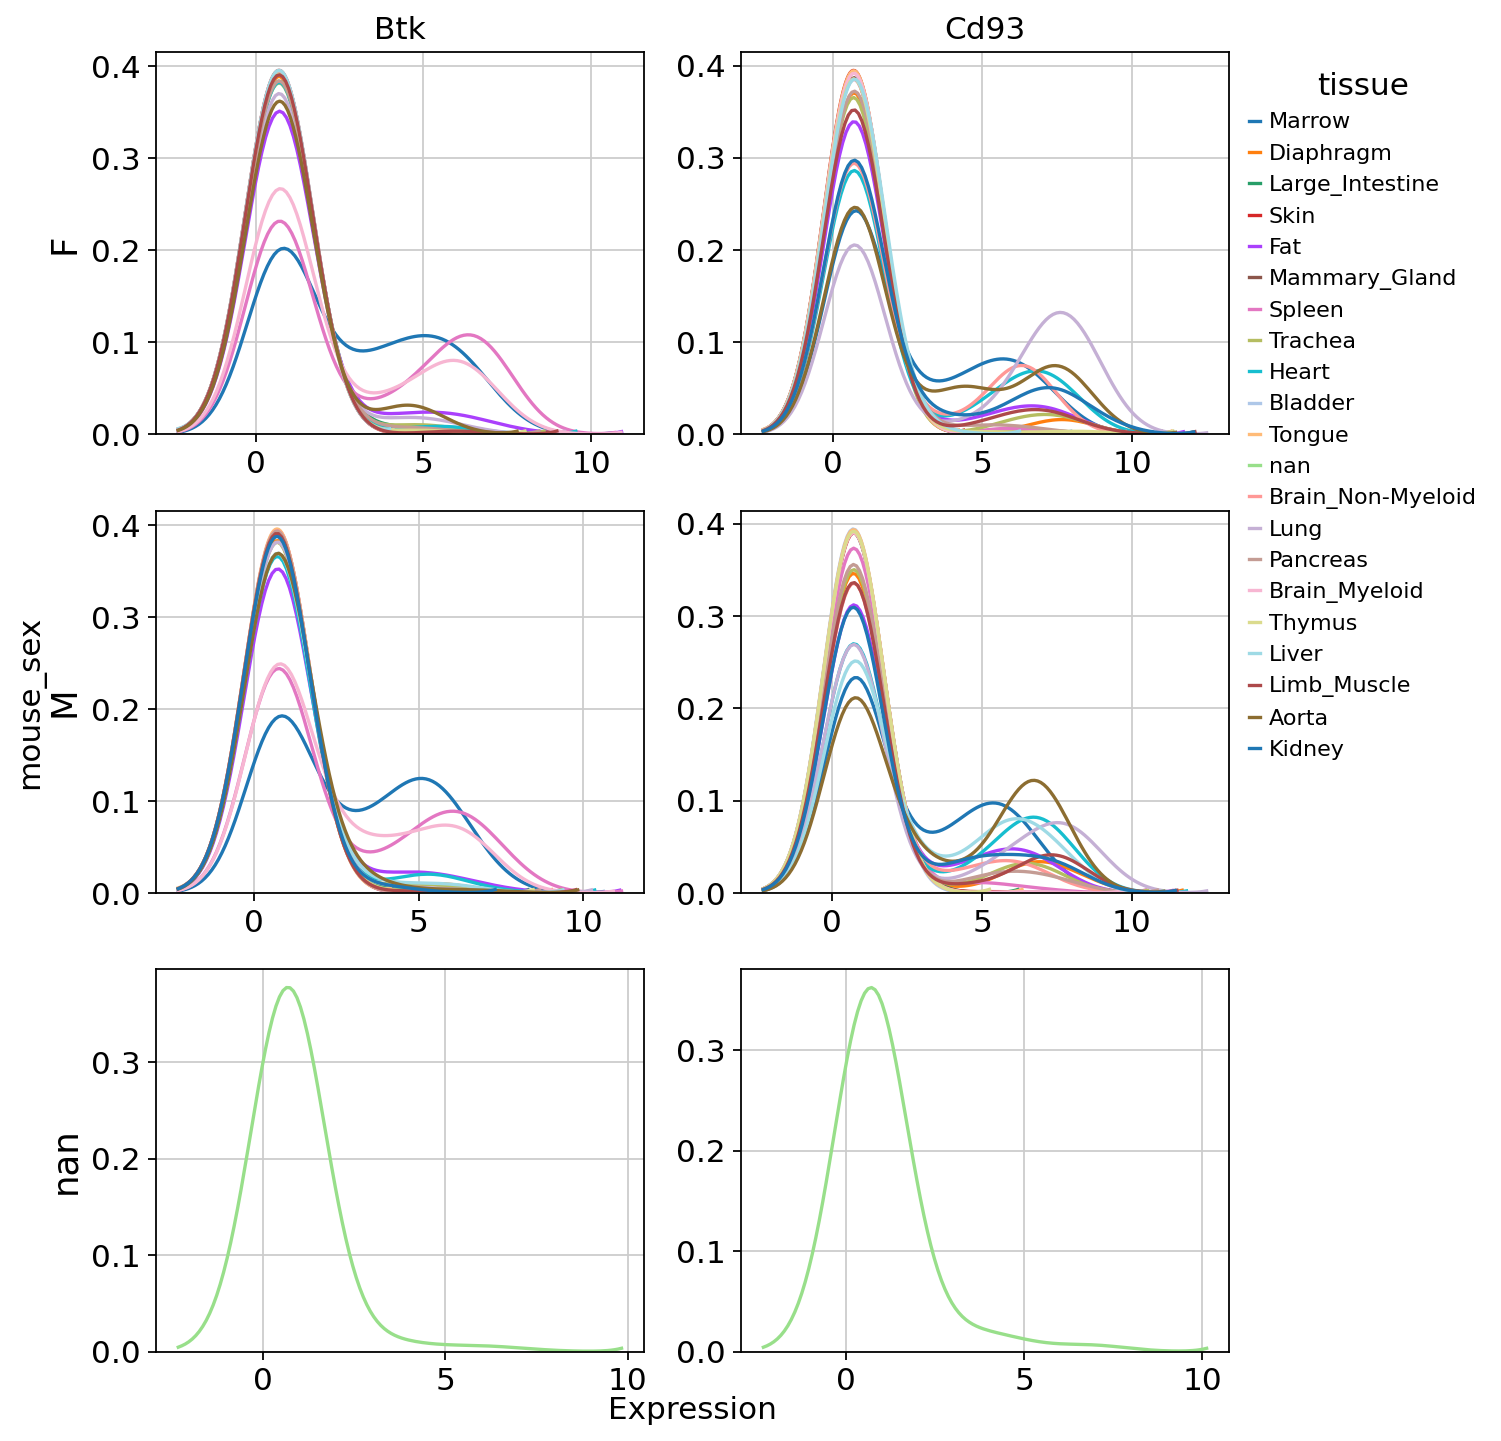

In [185]:
import warnings
sGrp = "mouse_sex"
cGrp = "tissue"
warnings.filterwarnings("ignore")
subSize = 4
bw=1
split = list(adata.obs[sGrp].unique())
genes = list(adata.var.index)
colGrp = list(adata.obs[cGrp].unique())
legendCol = math.ceil(len(colGrp)/(len(split)*11))
fig = plt.figure(figsize=(len(genes)*subSize,len(split)*(subSize-1)),frameon=False)
plt.xlabel("Expression",labelpad=20)
plt.ylabel(sGrp,labelpad=50)
plt.xticks([])
plt.yticks([])
plt.box(on=None)
gs = fig.add_gridspec(len(split),len(genes),wspace=0.2)#
for i in range(len(split)):
  Dobs = adata[adata.obs[sGrp]==split[i]].obs[cGrp]
  D = adata[adata.obs[sGrp]==split[i]].to_df()
  for j in range(len(genes)):
    ax = fig.add_subplot(gs[i,j])
    for one in colGrp:
      if sum(Dobs==one)<1:
        sns.kdeplot([0],label=one)
      else:
        sns.kdeplot(D[Dobs==one][genes[j]].to_numpy(),bw=bw,label=one)
    if i==0:
      ax.set_title(genes[j])
    if j==0:
      ax.set_ylabel(split[i],fontsize=16)
    if i==0 and j==(len(genes)-1):
      ax.legend(prop={'size': 10},title = cGrp,loc=2,bbox_to_anchor=(1,1),ncol=legendCol,frameon=False)#
    else:
      ax.get_legend().remove()
#fig.set_size_inches()
#fig.text(0.6,0.08,"Expression",ha='center')
fig.savefig('test.png',bbox_inches="tight")


In [62]:
colGrp

['4', '3', '1', '2']

In [18]:
data = {'method':"DUAL",#'HEAT','PGV', "GD",DEG,DOT,EMBED,TRAK
        #'cells':{'group1':{str(x):random.randint(1,20000) for x in range(500)},
        #      'group2':{str(x):random.randint(20000,45400) for x in range(500)}},#
        'cells':{str(x):random.randint(1,40000) for x in range(20000)},
        'genes':['BTK','SALL1'],#,#,"Fap","Acta2","Krt5",'Sall1','Pex7','Adh1','C1qa','C1qb','C1qc','Cd37','Cd84'
                #"Cd79a","Rac2","Coro1a"],#Scfd2,Pex7,Sall1//'Scfd2','Pezx7','Sall1','Cd53','Cd86','Cd84'
        #'genes':['Fxyd3','Lgals7','Acta2','Krt5','Cd79a','Rac2','Coro1a'],
        #'genes':[],
        'grp':['cell_type'],#clusters_louvain',cell_ontology_class;mouse_id;mouse_sex,'n_counts','n_genes'
        #'topN':"10",
        #'DEmethod':'wald',
        'norm':"zscore",
        'ncol':4,
        'layout':'umap',
        'cutoff':'1',
        'by':"Rows",
        'order':'cell_type',
        #'geneGrp':{'set1':['Fxyd3','Lgals7'],
        #           'set2':['Acta2','Krt5'],
        #           'set4':['Cd79a','Rac2','Coro1a']
        #          },
        'url':f'http://127.0.0.1:8888/{api_version}'
      }


In [42]:
scD = sc.read_h5ad("Data/concat_filtered_scaled_normalized_log1p_fixed_index.h5ad")
selC = list(data['cells'].values())
cName = ["cell%d" %i for i in selC]
fullG = list(scD.var.index)
selG = [fullG.index(i) for i in data['genes']]#
X = scD.X[selC][:,selG]
gNames = data['genes']
#gNames = fullG
#expr = pd.DataFrame.sparse.from_spmatrix(X,index=cName,columns=gNames)
#expr

obs = scD.obs.iloc[selC,:].loc[:,data['grp']].astype('str')
#obs['cluster'] = [random.randint(1,10) for x in range(1000)]
obs.index = cName
obs = obs.astype('category')
adata = sc.AnnData(X,obs,var=pd.DataFrame(gNames,index=gNames,columns=['gene_name']))#
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 20000 × 2 
    obs: 'cell_type'
    var: 'gene_name'

ValueError: setting an array element with a sequence.

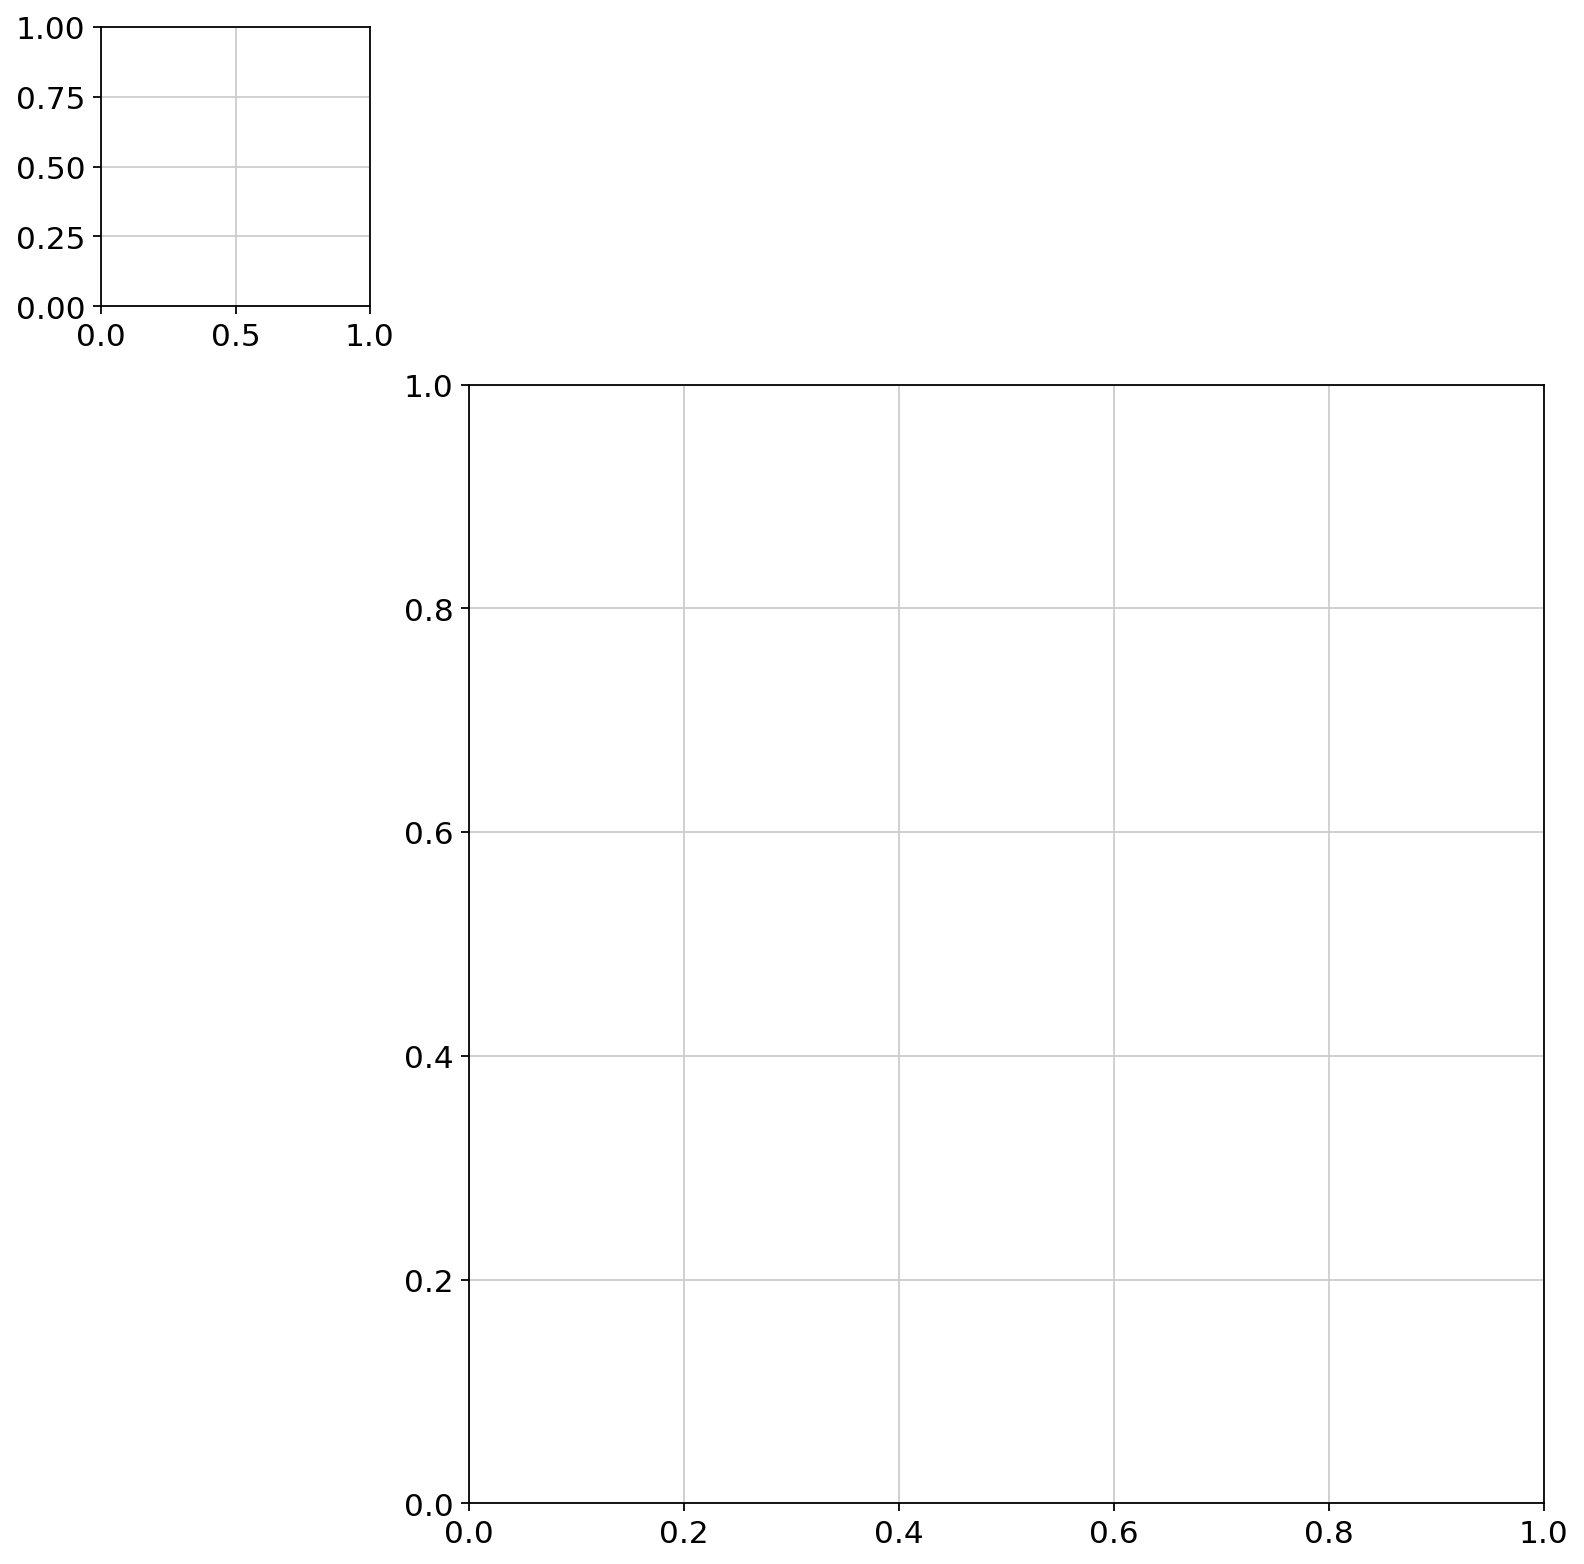

In [59]:
Zscore=None
heatCol=None
heatCenter=None
exprOrder = False
sns.clustermap(adata.X,method="ward",row_cluster=exprOrder,z_score=Zscore,cmap=heatCol)

In [56]:
import time
cutOff = 'geneN_cutoff'+data['cutoff']+"_"
sT = time.time()
adata.obs[cutOff] = adata.to_df().apply(lambda x: sum(x>float(data['cutoff'])),axis=1)
print(time.time() - sT)
sT = time.time()
df = adata.to_df()
adata.obs[cutOff+"1"] = df[df>float(data['cutoff'])].count(axis=1)
print(time.time() - sT)
sT = time.time()
adata.obs[cutOff+"2"] = (adata.X >float(data['cutoff'])).sum(1)
print(time.time() - sT)
adata.obs

1.4040582180023193
0.0028090476989746094
0.0009448528289794922


cell_type  geneN_cutoff1  geneN_cutoff11  geneN_cutoff12  \
cell25696         OPC              1               1               1   
cell11348       EN-L4              0               0               0   
cell35340  Astrocytes              0               0               0   
cell34828         nan              0               0               0   
cell13817     EN-L2-3              0               0               0   
...               ...            ...             ...             ...   
cell13729    IN-PVALB              0               0               0   
cell14707     EN-L2-3              0               0               0   
cell38295      IN-VIP              0               0               0   
cell7226          nan              0               0               0   
cell6924        EN-L4              0               0               0   

           geneN_cutoff1_  geneN_cutoff1_1  geneN_cutoff1_2  
cell25696               1                1                1  
cell11348               0                0                0  
cell35340               0                0                0  
cell34828               0                0                0  
cell13817               0                0                0  
...                   ...              ...              ...  
cell13729               0                0                0  
cell14707               0                0                0  
cell38295               0                0                0  
cell7226                0                0                0  
cell6924                0                0                0  

[20000 rows x 7 columns]

In [52]:
cutoff = 1
sT= time.time()
ix = adata.to_df().apply(lambda x: max(x)>float(cutoff),axis=1)
print(time.time() - sT)
sT= time.time()
df = adata.to_df()
ix = df[df>cutoff].count(axis=1)>0
print(time.time() - sT)
sT= time.time()
ix = pd.DataFrame((adata.X>float(data['cutoff'])).sum(1)>0,index=list(adata.obs.index)).iloc[:,0]
print(time.time() - sT)

0.08919477462768555
0.002481222152709961
0.0031690597534179688


In [54]:
type(ix)

pandas.core.series.Series

In [71]:
pCol = {"None":"#AAAAAA44","Both":"#EDDF01AA",data['genes'][0]:"#1CAF82AA",data['genes'][1]:"#FA2202AA"}
adata.obs['Expressed1'].value_counts()

None     19180
SALL1      767
BTK         49
Both         4
Name: Expressed1, dtype: int64

In [91]:
adata.obs['Expressed4'].value_counts()

None     19180
SALL1      767
BTK         49
Both         4
Name: Expressed4, dtype: int64

In [83]:
orr

cell38584     None
cell28851     None
cell32084     None
cell34234     None
cell6344      None
             ...  
cell7160      None
cell19908     None
cell32554    SALL1
cell37459     None
cell20707     None
Length: 20000, dtype: category
Categories (4, object): [BTK, Both, None, SALL1]

In [4]:
selC = list(data['cells'].values())
cName = ["cell%d" %i for i in selC]
fullG = list(scD.var.index)
selG = [fullG.index(i) for i in data['genes']]#
X = scD.X[selC][:,selG]
gNames = data['genes']
#gNames = fullG
#expr = pd.DataFrame.sparse.from_spmatrix(X,index=cName,columns=gNames)
#expr

obs = scD.obs.iloc[selC,:].loc[:,data['grp']].astype('str')
#obs['cluster'] = [random.randint(1,10) for x in range(1000)]
obs.index = cName
obs = obs.astype('category')
adata = sc.AnnData(X,obs,var=pd.DataFrame(gNames,index=gNames,columns=['gene_name']))#
adata
#list(set(list(adata.obs['louvain'])))
#sc.pl.violin(adata,data['genes'][0],groupby=data['grp'][0])
#Zscore=None
#heatCol=None
#heatCenter=None
#exprOrder = False
#sns.clustermap(adata.to_df(),method="ward",row_cluster=exprOrder,z_score=Zscore,cmap=heatCol)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 20000 × 2 
    obs: 'cell_type'
    var: 'gene_name'

In [236]:
data['genes'] = ['Btk','Sall1']
data['grp'] = ['mouse_sex','mouse_id']
selC = list(data['cells'].values())
cName = ["cell%d" %i for i in selC]
fullG = list(D.var.index)
selG = [fullG.index(i) for i in data['genes']]
X = D.X[selC][:,selG]
gNames = data['genes']
expr = pd.DataFrame(X,columns=gNames,index=cName)
pd.DataFrame(X,columns=gNames,index=cName)
obs = D.obs.iloc[selC,:].loc[:,data['grp']]
obs.index = cName
adata = sc.AnnData(expr,obs,var=pd.DataFrame([],index=gNames))

adata



Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 10000 × 2 
    obs: 'mouse_sex', 'mouse_id'

In [170]:
selC = list(data['cells'].values())
cName = ["cell%d" %i for i in selC]
fullG = list(scD.var.index)
selG = list(range(len(fullG)))#[fullG.index(i) for i in data['genes']]#
X = scD.X[selC][:,selG]
gNames = fullG

expr = pd.DataFrame.sparse.from_spmatrix(X,index=cName,columns=gNames)
expr

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
cell13493          0.0      0.0    0.0         0.0         0.0         0.0   
cell53875          0.0      0.0    0.0         0.0         0.0         0.0   
cell14684          0.0      0.0    0.0         0.0         0.0         0.0   
cell13865          0.0      0.0    0.0         0.0         0.0         0.0   
cell52898          0.0      0.0    0.0         0.0         0.0         0.0   
...                ...      ...    ...         ...         ...         ...   
cell50591          0.0      0.0    0.0         0.0         0.0         0.0   
cell50391          0.0      0.0    0.0         0.0         0.0         0.0   
cell61934          0.0      0.0    0.0         0.0         0.0         0.0   
cell30166          0.0      0.0    0.0         0.0         0.0         0.0   
cell63616          0.0      0.0    0.0         0.0         0.0         0.0   

           AL627309.4  AL732372.1  OR4F29  AC114498.1  ...  AC007325.2  \
cell13493         0.0         0.0     0.0         0.0  ...         0.0   
cell53875         0.0         0.0     0.0         0.0  ...         0.0   
cell14684         0.0         0.0     0.0         0.0  ...         0.0   
cell13865         0.0         0.0     0.0         0.0  ...         0.0   
cell52898         0.0         0.0     0.0         0.0  ...         0.0   
...               ...         ...     ...         ...  ...         ...   
cell50591         0.0         0.0     0.0         0.0  ...         0.0   
cell50391         0.0         0.0     0.0         0.0  ...         0.0   
cell61934         0.0         0.0     0.0         0.0  ...         0.0   
cell30166         0.0         0.0     0.0         0.0  ...         0.0   
cell63616         0.0         0.0     0.0         0.0  ...         0.0   

           BX072566.1  AL354822.1  AC023491.2  AC004556.1  AC233755.2  \
cell13493         0.0         0.0         0.0         0.0         0.0   
cell53875         0.0         0.0         0.0         0.0         0.0   
cell14684         0.0         0.0         0.0         0.0         0.0   
cell13865         0.0         0.0         0.0         0.0         0.0   
cell52898         0.0         0.0         0.0         0.0         0.0   
...               ...         ...         ...         ...         ...   
cell50591         0.0         0.0         0.0         0.0         0.0   
cell50391         0.0         0.0         0.0         0.0         0.0   
cell61934         0.0         0.0         0.0         0.0         0.0   
cell30166         0.0         0.0         0.0         0.0         0.0   
cell63616         0.0         0.0         0.0         0.0         0.0   

           AC233755.1  AC240274.1  AC213203.1  FAM231C  
cell13493         0.0         0.0         0.0      0.0  
cell53875         0.0         0.0         0.0      0.0  
cell14684         0.0         0.0         0.0      0.0  
cell13865         0.0         0.0         0.0      0.0  
cell52898         0.0         0.0         0.0      0.0  
...               ...         ...         ...      ...  
cell50591         0.0         0.0         0.0      0.0  
cell50391         0.0         0.0         0.0      0.0  
cell61934         0.0         0.0         0.0      0.0  
cell30166         0.0         0.0         0.0      0.0  
cell63616         0.0         0.0         0.0      0.0  

[10000 rows x 33525 columns]

In [171]:
expr.dtypes

MIR1302-2HG    Sparse[float32, 0.0]
FAM138A        Sparse[float32, 0.0]
OR4F5          Sparse[float32, 0.0]
AL627309.1     Sparse[float32, 0.0]
AL627309.3     Sparse[float32, 0.0]
                       ...         
AC233755.2     Sparse[float32, 0.0]
AC233755.1     Sparse[float32, 0.0]
AC240274.1     Sparse[float32, 0.0]
AC213203.1     Sparse[float32, 0.0]
FAM231C        Sparse[float32, 0.0]
Length: 33525, dtype: object

In [186]:
tmp = ['faaw','Other']
newGrp = "Custom"
obs= pd.DataFrame([tmp[random.randint(1,100)%2] for x in range()],columns=[newGrp])
selC1 = ~obs[newGrp].str.contains("Other")
X[selC1.to_numpy()]

<4970x2 sparse matrix of type '<class 'numpy.float32'>'
	with 255 stored elements in Compressed Sparse Row format>

In [154]:
scD.obs[data['grp']]

cell_type
index                                          
AAACCTGTCAGTTGAC-1-C1_10x_3PEE_ref   Astrocytes
AAACGGGAGACAAGCC-1-C1_10x_3PEE_ref        EN-L4
AAACGGGCAAATTGCC-1-C1_10x_3PEE_ref          OPC
AAACGGGCACGAGAGT-1-C1_10x_3PEE_ref      EN-L2-3
AAACGGGTCAACTCTT-1-C1_10x_3PEE_ref   Astrocytes
...                                         ...
TTTGTCAGTCTAGTCA-1-MS9_10x_3PEE_ref         nan
TTTGTCAGTTAAGAAC-1-MS9_10x_3PEE_ref         nan
TTTGTCAGTTAGGGTG-1-MS9_10x_3PEE_ref     EN-L2-3
TTTGTCATCGACCAGC-1-MS9_10x_3PEE_ref         OPC
TTTGTCATCTGATACG-1-MS9_10x_3PEE_ref         nan

[64868 rows x 1 columns]

Trying to set attribute `.uns` of view, copying.


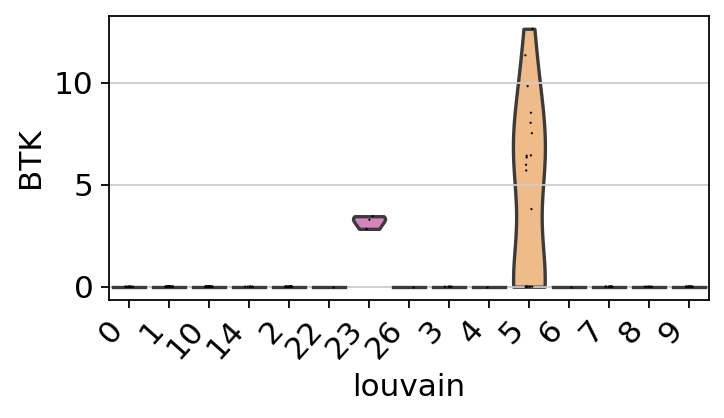

In [51]:
import math
def geneFiltering(adata,strCut,opt):
  ## 1. remove cells if the max expression of all genes is lower than the cutoff
  if opt==1:
    ix = adata.to_df().apply(lambda x: max(x)>float(strCut),axis=1)
    adata = adata[ix,]
  ## 2. Set all expression level smaller than the cutoff to be NaN not for plotting without removing any cells
  elif opt==2:
    def cutoff(x):
        return x if x>float(strCut) else None
    X = adata.to_df()
    X=X.applymap(cutoff)
    adata = sc.AnnData(X,adata.obs)
  return adata

def SGV(data,adata):
  # figure width and heights depends on number of unique categories
  # characters of category names, gene number
  adata = geneFiltering(adata,data['cutoff'],1)
  if len(adata)==0:
    return Msg('No cells in the condition!')

  a = list(set(list(adata.obs[data['grp'][0]])))
  ncharA = max([len(x) for x in a])
  w = len(a)/4+1
  h = ncharA/6+2.5
  ro = math.acos(10/max([15,ncharA]))/math.pi*180
  ##
  
  fig = plt.figure(figsize=[w,h])
  sc.pl.violin(adata,data['genes'][0],groupby=data['grp'][0],ax=fig.gca(),show=False)
  fig.autofmt_xdate(bottom=0.2,rotation=ro,ha='right')
#sc.set_figure_params(color_map='summer')
SGV(data,adata)


In [40]:
def cleanAbbr(data):
  updated = False
  if 'abb' in data.keys() and 'combine' in data.keys():
    if len(data['combine'])>0:
      updated = True
      for cate in data['abb'].keys():
        if cate in data['combine'].keys():
          for anName in data['abb'][cate].keys():
            if not anName in data['combine'][cate]:
              data['abb'][cate][anName] = "Other";
        else:
          data['abb'][cate] = {key:"Other" for key in data['abb'][cate].keys()}
  return updated


def createData(data,seperate=False):
  
  headers = {'content-type':'application/json'}
  # obtain the expression
  res = requests.get('%s/annotations/var' % data["url"],params={'annotation-name':'name_0'})
  gNames = decode_fbs.decode_matrix_FBS(res.content)['columns'][0]
  if not 'genes' in data:
    data['genes'] = gNames[0]
  if len(data['genes'])==0:# obtain all genes
    data['genes'] = gNames
    
  fil = json.dumps({'filter':{'var':{'annotation_value':[{'name':'name_0','values':data['genes']}]}}})
  res = requests.put('%s/data/var' % data["url"],fil,headers=headers)
  expr = decode_fbs.decode_matrix_FBS(res.content)
  cNames = ["cell%d" % x for x in data['cells'].values()]
  expr = pd.DataFrame([[expr['columns'][i][x] for x in data['cells'].values()] for i in range(len(expr['columns']))],
                        index=[gNames[x] for x in expr['col_idx']],columns=cNames).T

  ## obtain the embedding
  strEmbed = 'umap'
  embed = pd.DataFrame([[0 for x in range(len(cNames))] for i in range(2)],
                        index=['%s1'%strEmbed,'%s2'%strEmbed],columns=cNames).T
  if 'layout' in data.keys():## tsne or umap
    strEmbed = data['layout']
    res = requests.get('%s/layout/obs' % data["url"],params={'layout-name':strEmbed})
    embed= decode_fbs.decode_matrix_FBS(res.content)
    embed = pd.DataFrame([[embed['columns'][i][x] for x in data['cells'].values()] for i in range(len(embed['columns']))],
                          index=embed['col_idx'],columns=cNames).T

  # obtain the meta grouping
  obsL = [cNames]
  combUpdate = cleanAbbr(data)
  for one in data['grp']:
    res = requests.get('%s/annotations/obs' % data["url"],params={'annotation-name':one})
    grp = decode_fbs.decode_matrix_FBS(res.content)
    if 'abb' in data.keys():
      subGrp = [data['abb'][one][str(grp['columns'][0][i])] for i in data['cells'].values()]
    else:
      subGrp = [str(grp['columns'][0][i]) for i in data['cells'].values()]
    obsL += [subGrp]
  obs = pd.DataFrame(obsL,index=['name_0']+data['grp'],columns=cNames).T

  if combUpdate and len(data['grp'])>1:
    newGrp = 'Custom_combine'
    obs[newGrp] = obs[data['grp'][0]]
    for i in data['grp']:
      if i!=data['grp'][0]:
        obs[newGrp] += "_"+obs[i]
    expr = expr[~obs[newGrp].str.contains("Other")]
    embed = embed[~obs[newGrp].str.contains("Other")]
    obs = obs[~obs[newGrp].str.contains("Other")]
    data['grp'] = [newGrp]

  obs = obs.astype('category')
  ## empty selection
  if expr.shape[0]==0 or expr.shape[1]==0:
    return []
  
  return sc.AnnData(expr,obs,obsm={'X_%s'%strEmbed:embed.to_numpy()})
import time
sT = time.time()
adata = createData(data)
print(time.time()-sT)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


1.8335528373718262


In [67]:
data['genes'] = ['BTK']
headers = {'content-type':'application/json'}
  # obtain the expression
res = requests.get('%s/annotations/var' % data["url"],params={'annotation-name':'name_0'})
gNames = decode_fbs.decode_matrix_FBS(res.content)['columns'][0]
if not 'genes' in data:
  data['genes'] = gNames[0]
if len(data['genes'])==0:# obtain all genes
  data['genes'] = gNames
    
fil = json.dumps({'filter':{'var':{'annotation_value':[{'name':'name_0','values':data['genes']}]}}})
res = requests.put('%s/data/var' % data["url"],fil,headers=headers)
expr = decode_fbs.decode_matrix_FBS(res.content)
cNames = ["cell%d" % x for x in data['cells'].values()]
expr = pd.DataFrame([[expr['columns'][i][x] for x in data['cells'].values()] for i in range(len(expr['columns']))],
                        index=[gNames[x] for x in expr['col_idx']],columns=cNames).T



33

In [263]:
html= """
  <html><body>
  <img src="data:image/svg+xml;base64,{}"/>
  </body></html>
  """
#png
def iostreamFig(fig):
    figD = BytesIO()
    fig.savefig(figD,format='svg',bbox_inches="tight")#png
    imgD = base64.encodebytes(figD.getvalue()).decode("utf-8")
    figD.close()
    plt.close('all')
    return imgD
HTML(html.format(iostreamFig(g)))

<ipython-input-263-e282a1f9df06>:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(figD,format='svg',bbox_inches="tight")#png


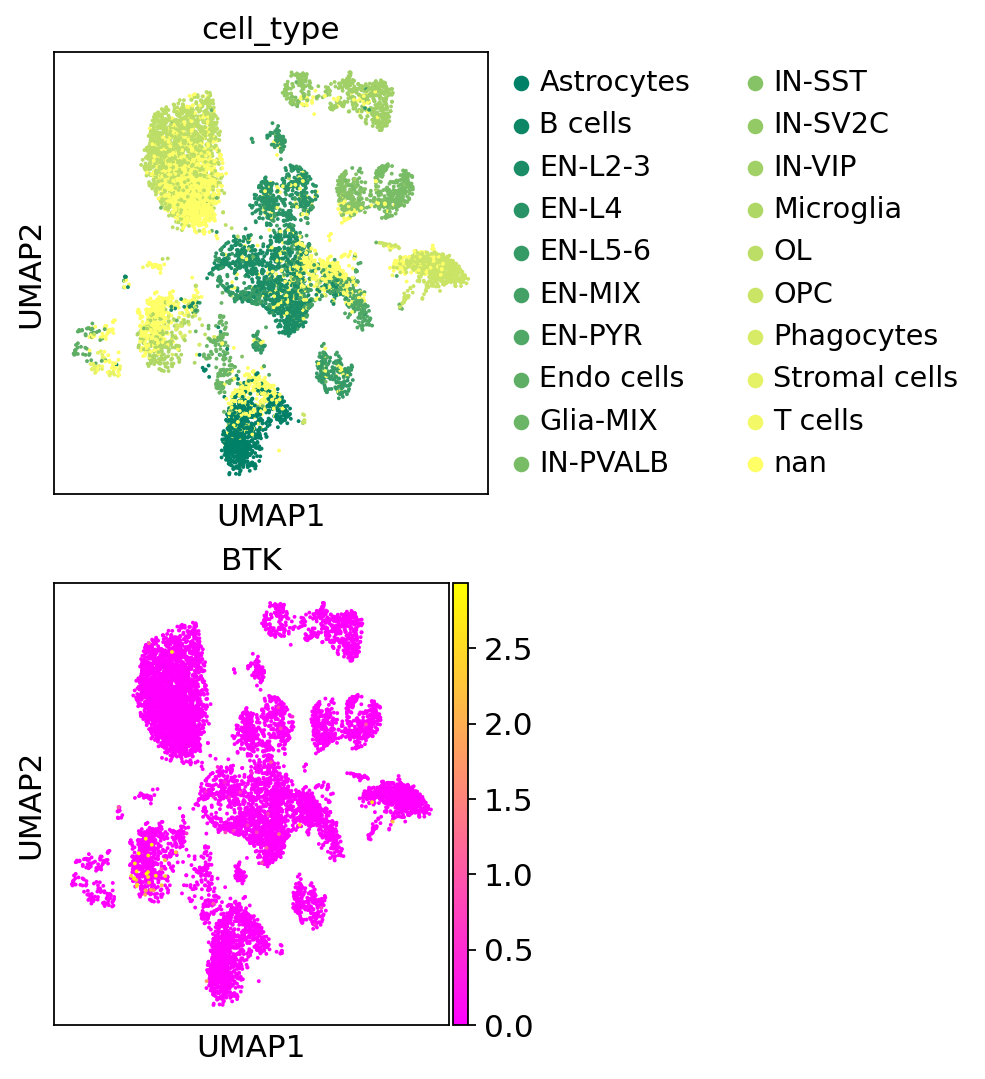

In [46]:
import math
def EMBED(data,adata):
    subSize = 4
    ncol = int(data['ncol'])
    ngrp = len(data['grp'])
    ngene = len(data['genes'])
    nrow = ngrp+math.ceil(ngene/ncol)
  
    step =11
    grpCol = {gID:math.ceil(len(list(adata.obs[gID].unique()))/step) for gID in data['grp']}

    fig = plt.figure(figsize=(ncol*subSize,subSize*nrow))
    gs = fig.add_gridspec(nrow,ncol,wspace=0.2)#
    
    for i in range(ngrp):
        ax = getattr(sc.pl,data['layout'])(adata=adata,color=data['grp'][i],ax=fig.add_subplot(gs[i,0]),palette="summer",show=False)
        if grpCol[data['grp'][i]]>3:
            ax.legend(ncol=grpCol[data['grp'][i]],loc=6,bbox_to_anchor=(1,0.5),frameon=False)
    for i in range(ngene):
        x = int(i/ncol)+ngrp
        y = i % ncol
        getattr(sc.pl,data['layout'])(adata,color=data['genes'][i],ax=fig.add_subplot(gs[x,y]),show=False)
    return fig
#adata = D[list(data['cells'].values()),data['genes']]
sc.set_figure_params(color_map='spring')
g =EMBED(data,adata)

In [236]:
grpCol

NameError: name 'grpCol' is not defined

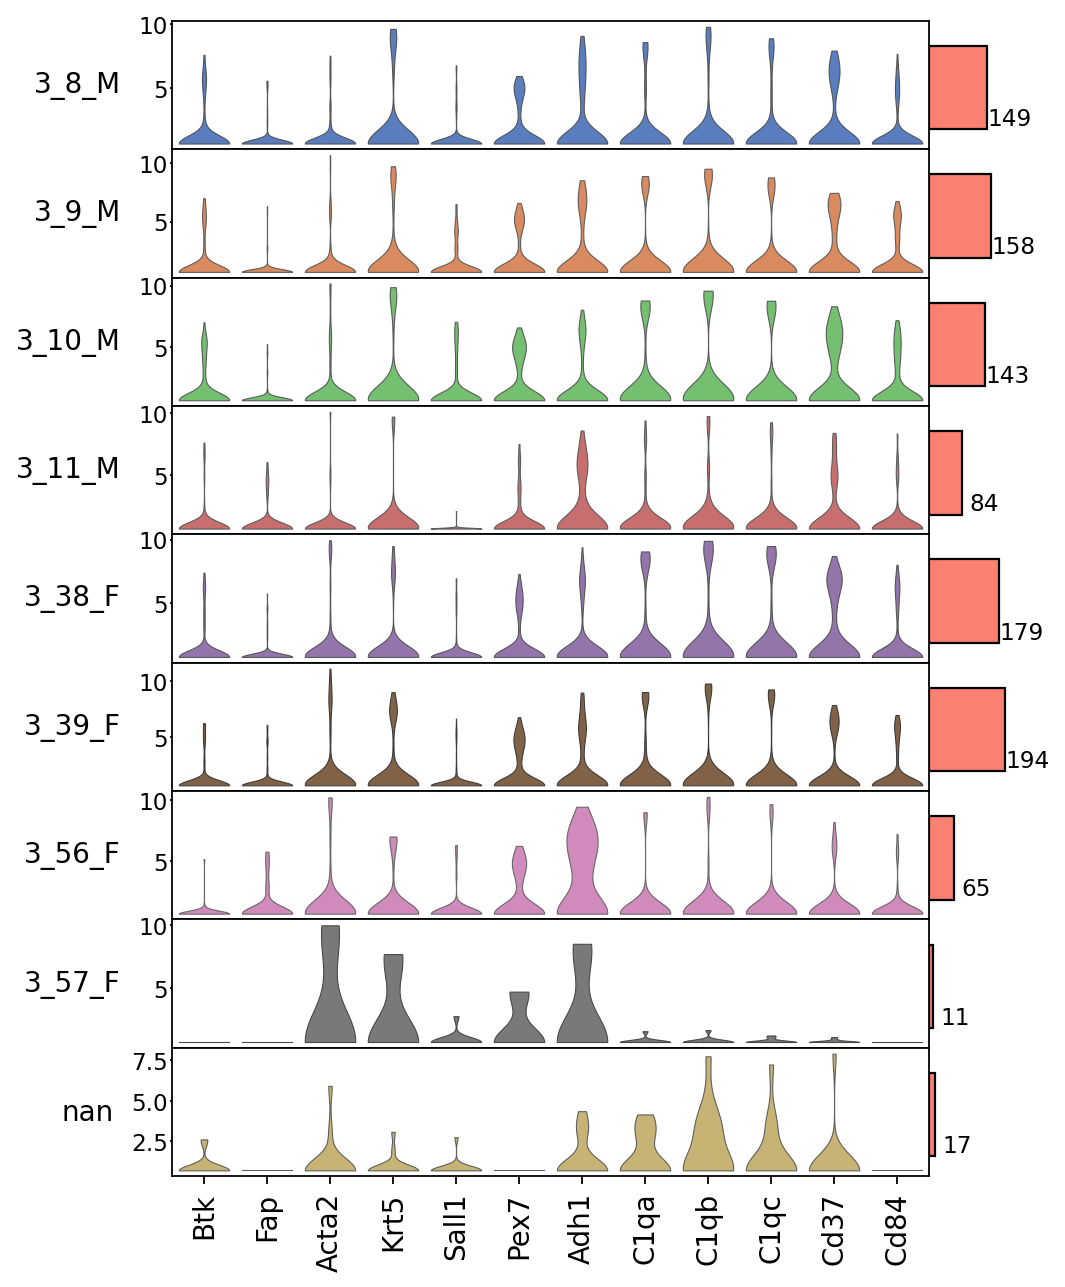

In [217]:
adata = D[list(data['cells'].values()),data['genes']]
#ix = adata.to_df().apply(lambda x: max(x)>1,axis=1)
#adata = adata[ix,]
def PGV(data,adata):
    
    a = list(set(list(adata.obs[data['grp'][0]])))
    ncharA = max([len(x) for x in a])
    w = ncharA/8+len(data['genes'])/2+0.5
    h = len(a)+0.5
    swapAx = False
    ##
    if data['by']=='Columns':
        a = w
        w = h
        h = a
        swapAx = True

    rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=12) 
    #plt.figure(figsize=[w,h])
    vp = getattr(sc.pl,'stacked_violin')(adata,data['genes'],groupby=data['grp'][0],return_fig=True,figsize=(w,h),swap_axes=swapAx)
    vp.add_totals().style(yticklabels=True).show()
PGV(data,adata)


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/oyoung/anaconda3/envs/cellxgene/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


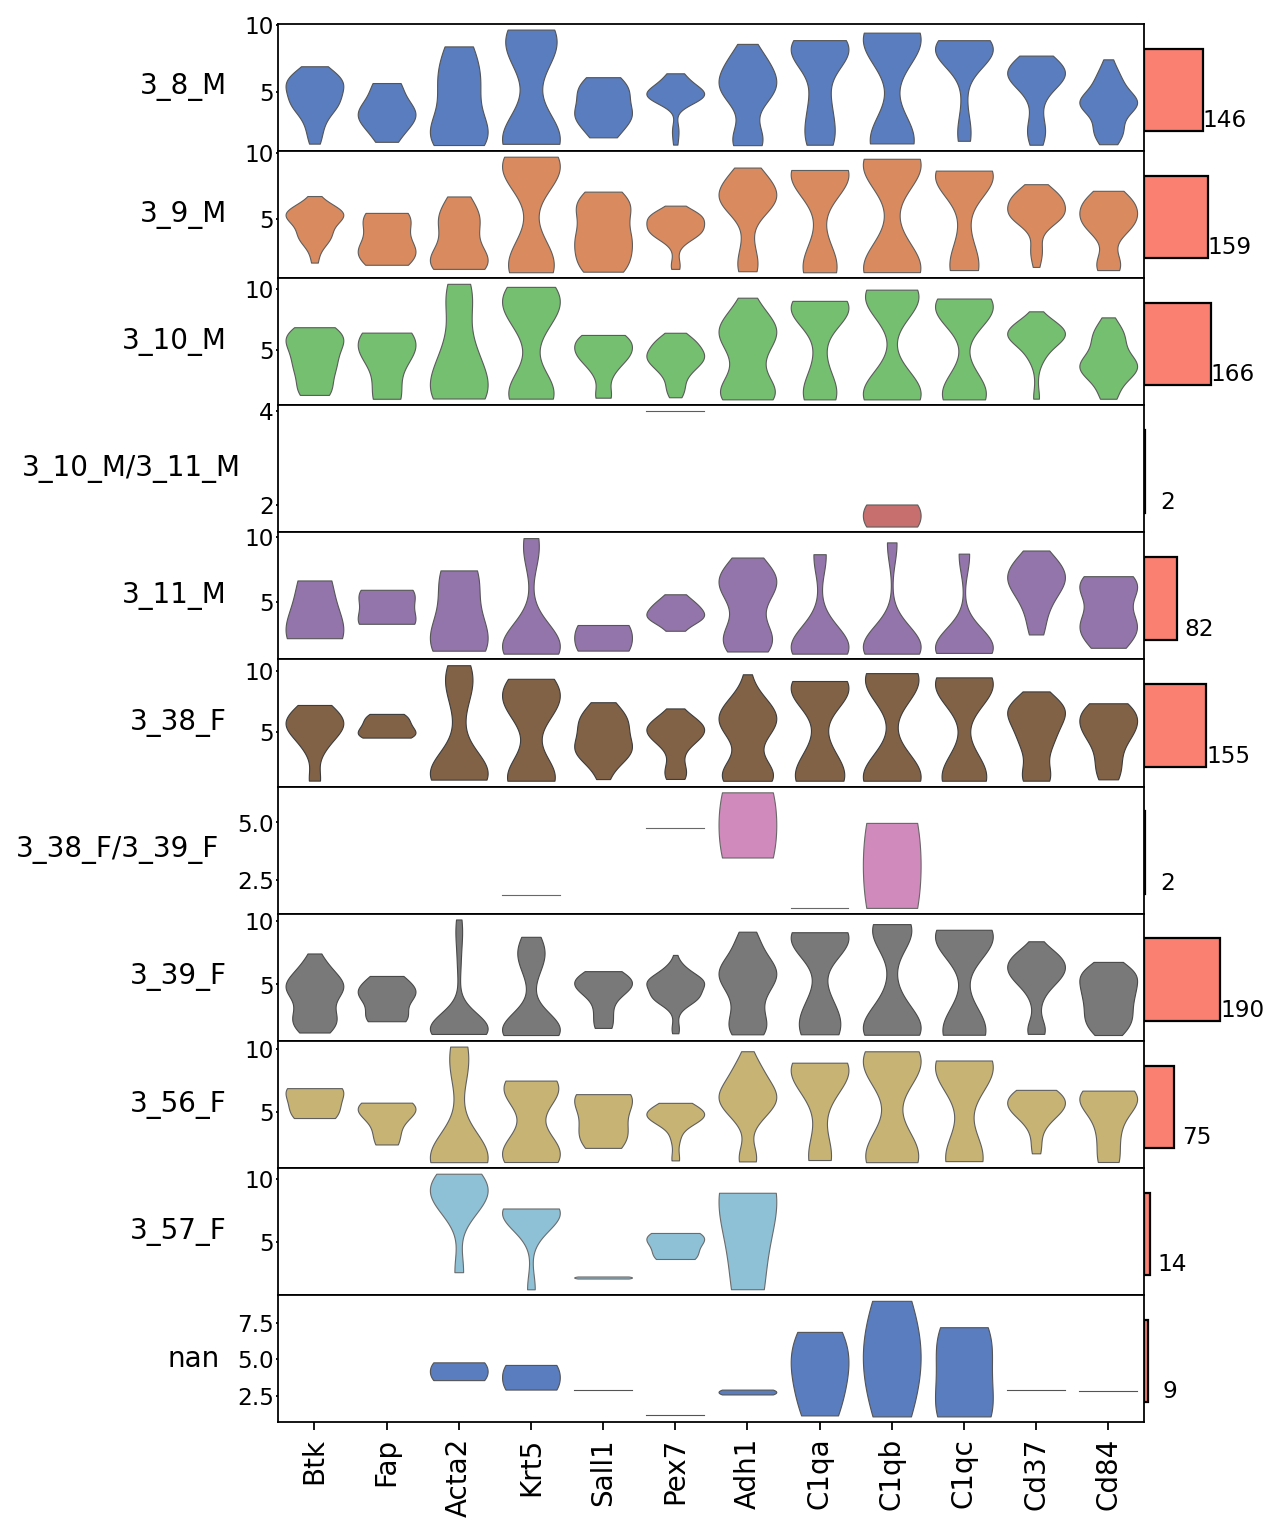

In [207]:
adata = D[list(data['cells'].values()),data['genes']]
def cutoff(x):
    return x if x>1 else None
X = adata.to_df()
X=X.applymap(cutoff)
adata.obs
adata1 = sc.AnnData(X,adata.obs)
PGV(data,adata1)

In [206]:
adata1.to_df()

index                          Btk       Fap     Acta2      Krt5     Sall1  \
index                                                                        
I12.MAA000603.3_10_M.1.1       NaN  0.693147  0.693147  0.693147  1.446945   
N3.MAA000487.3_10_M.1.1   0.693147  0.693147  4.895175  0.693147  0.693147   
M1.MAA000639.3_9_M.1.1    1.741003  0.693147  2.705427  0.693147  0.693147   
G20.MAA000884.3_10_M.1.1  0.693147  0.693147  0.693147  0.693147  2.956157   
B1.MAA000559.3_8_M.1.1    0.693147  0.693147  0.693147  0.693147  0.693147   
...                            ...       ...       ...       ...       ...   
H11.MAA000871.3_11_M.1.1  0.693147  0.693147  0.693147  0.693147  0.693147   
E9.MAA000398.3_9_M.1.1    5.402543  0.693147  0.693147  0.693147  0.693147   
C14.MAA000913.3_9_M.1.1   4.568526  0.693147  0.693147  0.693147  0.693147   
C2.MAA000938.3_8_M.1.1    0.693147  0.693147  0.693147  9.214075  1.596739   
H5.D042479.3_8_M.1.1      0.693147  0.693147  0.693147  0.693147  0.693147   

index                         Pex7      Adh1      C1qa      C1qb      C1qc  \
index                                                                        
I12.MAA000603.3_10_M.1.1  0.693147  0.693147  8.248708  9.113464  8.180510   
N3.MAA000487.3_10_M.1.1   0.693147  2.098209  0.693147  1.172579  0.693147   
M1.MAA000639.3_9_M.1.1    0.693147  0.693147  0.693147  0.693147  0.693147   
G20.MAA000884.3_10_M.1.1  0.693147  0.693147  5.489038  0.693147  0.693147   
B1.MAA000559.3_8_M.1.1    4.594231  0.693147  0.693147  0.693147  0.693147   
...                            ...       ...       ...       ...       ...   
H11.MAA000871.3_11_M.1.1  0.693147  0.693147  0.693147  0.693147  0.693147   
E9.MAA000398.3_9_M.1.1    5.600245  0.693147  8.527462  9.500650  8.444031   
C14.MAA000913.3_9_M.1.1   0.693147  0.693147  0.693147  0.693147  0.693147   
C2.MAA000938.3_8_M.1.1    0.693147  0.693147  1.596739  2.063543  2.063543   
H5.D042479.3_8_M.1.1      0.693147  0.693147  0.693147  0.693147  0.693147   

index                         Cd37      Cd84  
index                                         
I12.MAA000603.3_10_M.1.1  7.325527  0.693147  
N3.MAA000487.3_10_M.1.1   0.693147  0.693147  
M1.MAA000639.3_9_M.1.1    0.693147  0.693147  
G20.MAA000884.3_10_M.1.1  0.693147  0.693147  
B1.MAA000559.3_8_M.1.1    0.693147  4.515872  
...                            ...       ...  
H11.MAA000871.3_11_M.1.1  0.693147  0.693147  
E9.MAA000398.3_9_M.1.1    5.227823  4.150445  
C14.MAA000913.3_9_M.1.1   2.437133  0.693147  
C2.MAA000938.3_8_M.1.1    1.596739  0.693147  
H5.D042479.3_8_M.1.1      6.706649  0.693147  

[1000 rows x 12 columns]

In [164]:
adata = None
if len(data['cells'])==1:
    adata = D[list(data['cells'].values()),data['genes']]
else:
    for one in data['cells'].keys():
        oneD = D[list(data['cells'][one].values()),]
        oneD.obs['cellGrp'] = one
        if adata is None:
            adata = oneD
        else:
            adata = adata.concatenate(oneD)
import diffxpy.api as de
def DEG(data,adata):
    adata.obs.astype('category')
    res = de.test.two_sample(adata,'cellGrp',test=data['DEmethod'],noise_model='nb',backend='tf1')#Wald: 
    return res.summary()

testL = DEG(data,adata)
testL

Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


ValueError: type <class 'tuple'> not recognized

In [105]:
fig = axes['mainplot_ax'].figure

TypeError: 'NoneType' object is not subscriptable

In [120]:
def dotplot(data,adata):
    grp = adata.obs[data['grp'][0]].unique()
    if len(grp)<10:
        col = np.array(sns.color_palette('Set1',len(grp)).as_hex())
    elif len(grp)<20:
        col = np.array(sns.color_palette(n_colors=len(grp)).as_hex())
    else:
        col = np.array(sns.color_palette("husl",len(grp)).as_hex())
    adata.uns[data['grp'][0]+'_colors'] = col

    dp = sc.pl.dotplot(adata,data['geneGrp'],groupby=data['grp'][0],expression_cutoff=float(data['cutoff']),return_fig=True)#
    dp = dp.add_totals(size=1.2).legend(show_size_legend=True).style(cmap='Blues', dot_edge_color='black', dot_edge_lw=1, size_exponent=1.5)
    dp.show(False)
    fig = dp.get_axes()['mainplot_ax'].figure
    fig.savefig('test.png')

5.29